EDA & Statistical Analysis
Objective: Explore the cleaned, merged dataset. We will analyze distributions, find correlations, and perform grouped analysis to understand the drivers of water consumption and identify patterns related to meter characteristics.



# EDA & Statistical Analysis

**Objective:** Explore the cleaned, merged dataset. We will analyze distributions, find correlations, and perform grouped analysis to understand the drivers of water consumption and identify patterns related to meter characteristics.

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set some nice defaults for our plots
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

# Load the clean dataset
file_path = "data/processed/meter_weather_clean.parquet"
df_clean = pd.read_parquet(file_path)

# Quick check to confirm everything loaded correctly
print(f"Loaded data with shape: {df_clean.shape}")
display(df_clean.info())
display(df_clean.head())

Loaded data with shape: (5799919, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5799919 entries, 0 to 5799918
Data columns (total 31 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   POLIZA_SUMINISTRO            object        
 1   FECHA                        datetime64[ns]
 2   CONSUMO_REAL                 int64         
 3   SECCIO_CENSAL                float64       
 4   NUM_DTE_MUNI                 float64       
 5   NUM_COMPLET                  object        
 6   DATA_INST_COMP               datetime64[ns]
 7   tavg                         float64       
 8   tmin                         float64       
 9   tmax                         float64       
 10  prcp                         float64       
 11  US_AIGUA_GEST_C              bool          
 12  US_AIGUA_GEST_D              bool          
 13  CODI_MODEL_4.0               bool          
 14  CODI_MODEL_21.0              bool          
 15  CODI_MODEL_

None

,POLIZA_SUMINISTRO,FECHA,CONSUMO_REAL,SECCIO_CENSAL,NUM_DTE_MUNI,NUM_COMPLET,DATA_INST_COMP,tavg,tmin,tmax,...,CODI_MODEL_66.0,CODI_MODEL_73.0,MARCA_COMP_7WZSCJKXGT7J2Q5E,MARCA_COMP_OKV4SQYX72EBODPA,MARCA_COMP_R7GO7PZAU5F6DHFH,NUM_MUN_SGAB_10.0,NUM_MUN_SGAB_25.0,NUM_MUN_SGAB_47.0,DIAM_COMP_20.0,DIAM_COMP_30.0
0,VECWAVDUULZDSBOP,2021-01-01,1758,801903025.0,3.0,N5ER4KUNPNXOQQCE,2016-04-25,7.2,5.3,8.5,...,False,False,False,False,False,False,False,False,False,True
1,VECWAVDUULZDSBOP,2021-01-02,1854,801903025.0,3.0,N5ER4KUNPNXOQQCE,2016-04-25,5.7,2.7,9.7,...,False,False,False,False,False,False,False,False,False,True
2,VECWAVDUULZDSBOP,2021-01-03,1885,801903025.0,3.0,N5ER4KUNPNXOQQCE,2016-04-25,5.4,1.4,9.7,...,False,False,False,False,False,False,False,False,False,True
3,VECWAVDUULZDSBOP,2021-01-04,5676,801903025.0,3.0,N5ER4KUNPNXOQQCE,2016-04-25,4.9,0.5,11.3,...,False,False,False,False,False,False,False,False,False,True
4,VECWAVDUULZDSBOP,2021-01-05,4456,801903025.0,3.0,N5ER4KUNPNXOQQCE,2016-04-25,3.8,0.6,10.1,...,False,False,False,False,False,False,False,False,False,True



The first step is a correlation matrix

Since our DataFrame has many dummy variables, a matrix of the whole thing would be unreadable. Let's start with a focused heatmap of the core numeric variables: consumption and weather.

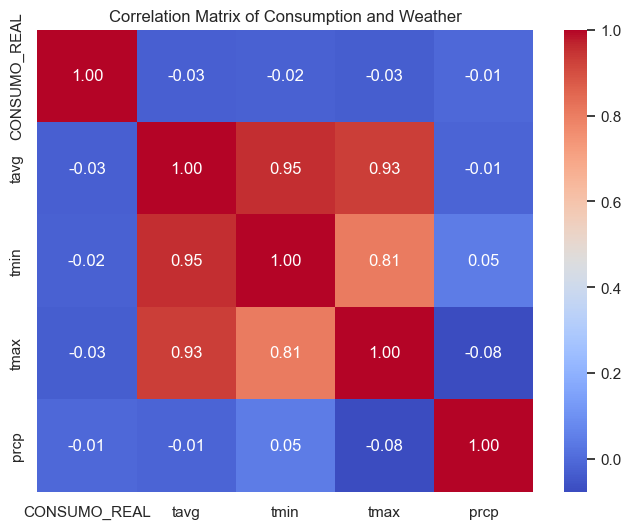

In [18]:
# Let's analyze the correlation between the key numeric features
numeric_features = [
    'CONSUMO_REAL', 
    'tavg', 
    'tmin', 
    'tmax', 
    'prcp'
]

# Calculate the correlation matrix
corr_matrix = df_clean[numeric_features].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    corr_matrix, 
    annot=True,     # Show the correlation values
    cmap='coolwarm',# Use a blue-to-red color map
    fmt=".2f"       # Format the numbers to 2 decimal places
)
plt.title('Correlation Matrix of Consumption and Weather')
plt.show()

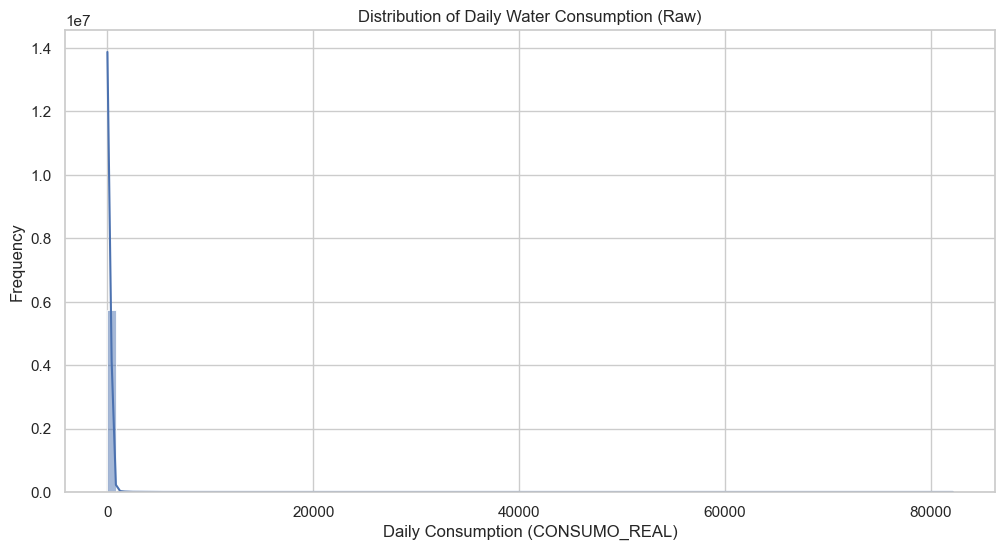

In [19]:
# Plot the distribution of the target variable, CONSUMO_REAL
plt.figure(figsize=(12, 6))
sns.histplot(df_clean['CONSUMO_REAL'], kde=True, bins=100)
plt.title('Distribution of Daily Water Consumption (Raw)')
plt.xlabel('Daily Consumption (CONSUMO_REAL)')
plt.ylabel('Frequency')
plt.show()

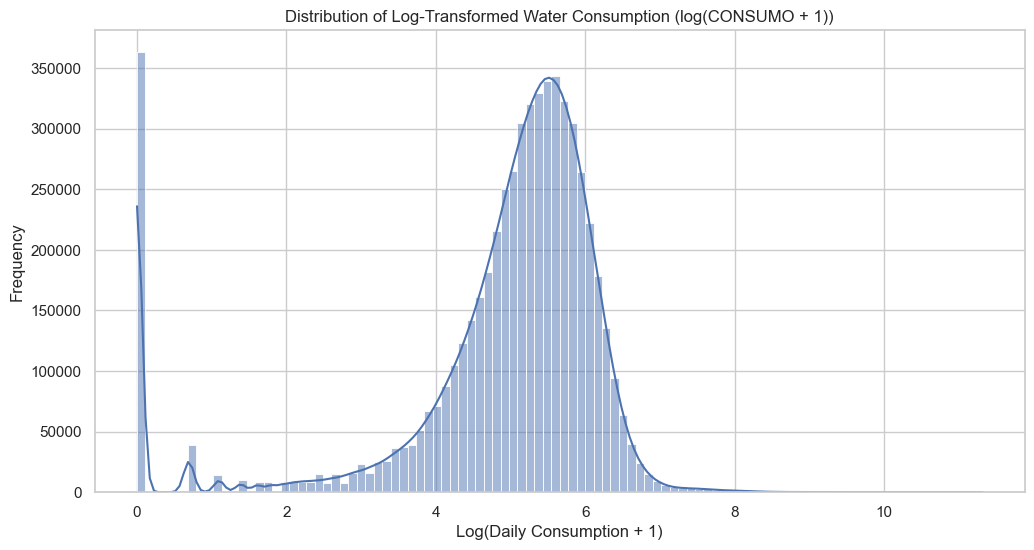

In [20]:
import numpy as np

# Create a new column for log-transformed consumption
# We use .copy() to avoid the SettingWithCopyWarning
df_clean = df_clean.copy()
df_clean['CONSUMO_LOG'] = np.log1p(df_clean['CONSUMO_REAL'])

# Plot the distribution of the new log-transformed variable
plt.figure(figsize=(12, 6))
sns.histplot(df_clean['CONSUMO_LOG'], kde=True, bins=100)
plt.title('Distribution of Log-Transformed Water Consumption (log(CONSUMO + 1))')
plt.xlabel('Log(Daily Consumption + 1)')
plt.ylabel('Frequency')
plt.show()

From this plot we can see that there are still null consumption values. May these be seen as invalid, there will in fact be relevant to the scope of our project, since we can relate them to water meter's anomalies or failures 

## Grouped Analysis (Categorical EDA)

Now that we have a good understanding of the *overall* consumption distribution (`CONSUMO_LOG`), we will follow the plan to analyze consumption by different groups.

Our main `df_clean` dataset is perfect for modeling, but its categorical columns (`MARCA_COMP`, `US_AIGUA_GEST`, etc.) were converted into `True`/`False` dummy variables (e.g., `MARCA_COMP_Brand_B`). This makes it difficult to create plots like "Consumption *by* Brand."

To solve this, we will now load the `meter_weather_pre_dummies.parquet` file we saved. This file contains the merged data from *just before* the `pd.get_dummies()` step. We will use this `df_plot` DataFrame for all our categorical visualizations.

In [21]:


# Load the pre-dummy dataset for categorical plotting
df_plot = pd.read_parquet("data/processed/meter_weather_pre_dummies.parquet")

# We still need to create the CONSUMO_LOG column for this DataFrame
df_plot['CONSUMO_LOG'] = np.log1p(df_plot['CONSUMO_REAL'])

print(f"Loaded pre-dummy data with shape: {df_plot.shape}")
display(df_plot.head())

Loaded pre-dummy data with shape: (5799919, 17)


,POLIZA_SUMINISTRO,FECHA,CONSUMO_REAL,SECCIO_CENSAL,US_AIGUA_GEST,NUM_MUN_SGAB,NUM_DTE_MUNI,NUM_COMPLET,DATA_INST_COMP,MARCA_COMP,CODI_MODEL,DIAM_COMP,tavg,tmin,tmax,prcp,CONSUMO_LOG
0,VECWAVDUULZDSBOP,2021-01-01,1758,801903025.0,C,0.0,3.0,N5ER4KUNPNXOQQCE,2016-04-25,5557SZ47QZAZ56EQ,23.0,30.0,7.2,5.3,8.5,10.1,7.472501
1,VECWAVDUULZDSBOP,2021-01-02,1854,801903025.0,C,0.0,3.0,N5ER4KUNPNXOQQCE,2016-04-25,5557SZ47QZAZ56EQ,23.0,30.0,5.7,2.7,9.7,0.0,7.525640
2,VECWAVDUULZDSBOP,2021-01-03,1885,801903025.0,C,0.0,3.0,N5ER4KUNPNXOQQCE,2016-04-25,5557SZ47QZAZ56EQ,23.0,30.0,5.4,1.4,9.7,0.0,7.542213
3,VECWAVDUULZDSBOP,2021-01-04,5676,801903025.0,C,0.0,3.0,N5ER4KUNPNXOQQCE,2016-04-25,5557SZ47QZAZ56EQ,23.0,30.0,4.9,0.5,11.3,0.0,8.644178
4,VECWAVDUULZDSBOP,2021-01-05,4456,801903025.0,C,0.0,3.0,N5ER4KUNPNXOQQCE,2016-04-25,5557SZ47QZAZ56EQ,23.0,30.0,3.8,0.6,10.1,0.0,8.402231


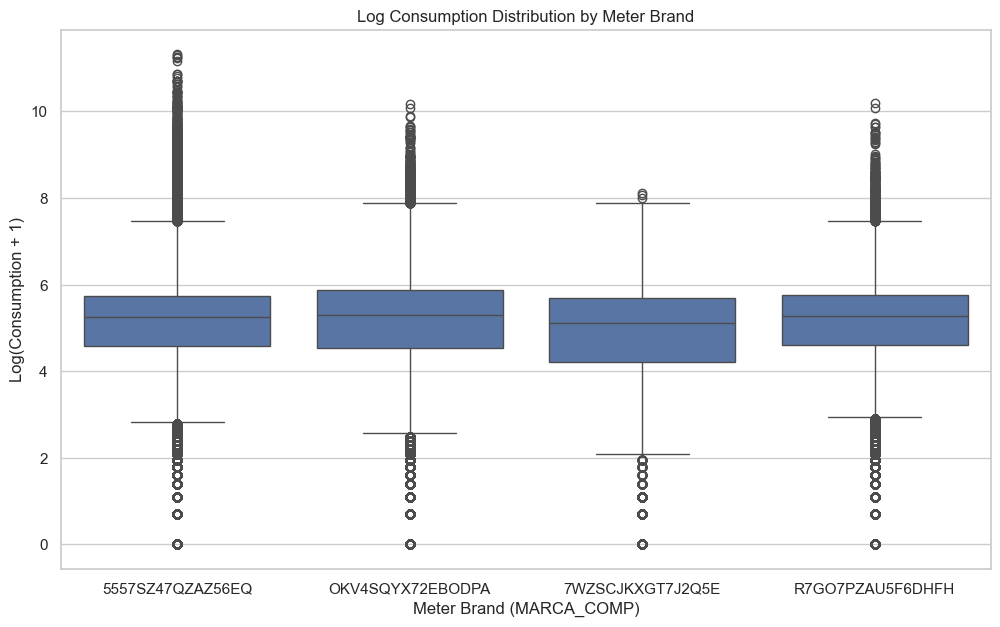

In [22]:
# Plot CONSUMO_LOG grouped by MARCA_COMP
plt.figure(figsize=(12, 7))
sns.boxplot(
    data=df_plot, 
    x='MARCA_COMP', 
    y='CONSUMO_LOG'
)
plt.title('Log Consumption Distribution by Meter Brand')
plt.xlabel('Meter Brand (MARCA_COMP)')
plt.ylabel('Log(Consumption + 1)')
plt.show()

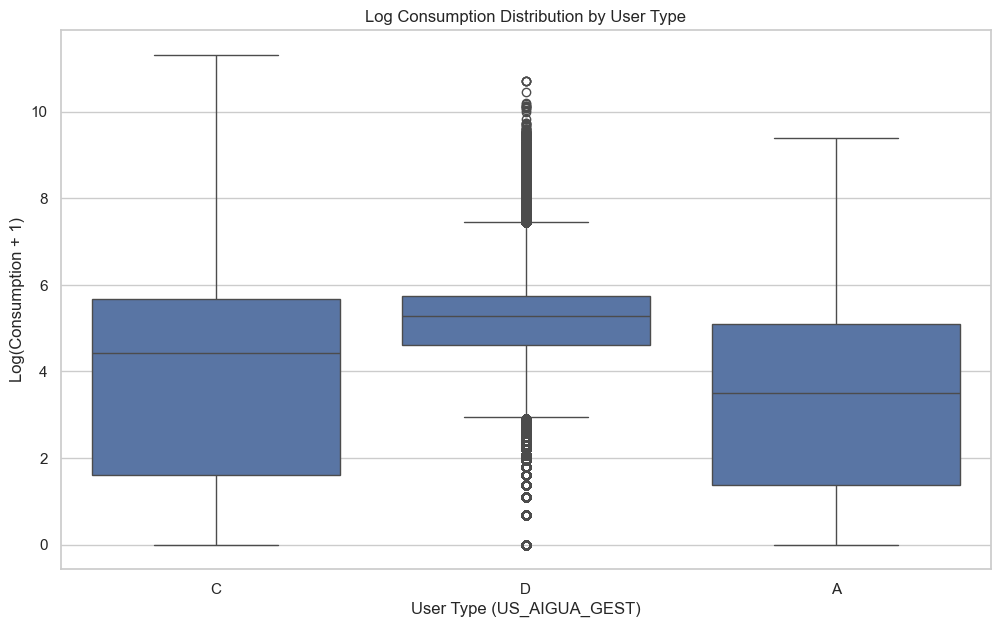

In [23]:
# Plot CONSUMO_LOG grouped by US_AIGUA_GEST
plt.figure(figsize=(12, 7))
sns.boxplot(
    data=df_plot, 
    x='US_AIGUA_GEST', 
    y='CONSUMO_LOG'
)
plt.title('Log Consumption Distribution by User Type')
plt.xlabel('User Type (US_AIGUA_GEST)')
plt.ylabel('Log(Consumption + 1)')
plt.show()

### Insights: Consumption by User Type

This plot shows `US_AIGUA_GEST` is a critical predictive feature, as the three user types (A, C, D) have distinct consumption patterns.

* **Group D:** Has the highest median consumption and a very narrow, predictable "normal" range. It also has a massive number of both high and low outliers.
* **Group C:** Has a lower median but a much **wider** distribution, indicating highly variable consumption. This group accounts for many of the highest consumption days.
* **Group A:** Has the **lowest median consumption** and a wide, variable distribution, but very few outliers.

**Key Takeaway:** A model will need to learn these three different patterns. An anomalous reading in one group (like a zero in Group C) might be considered a common outlier in another (Group D).

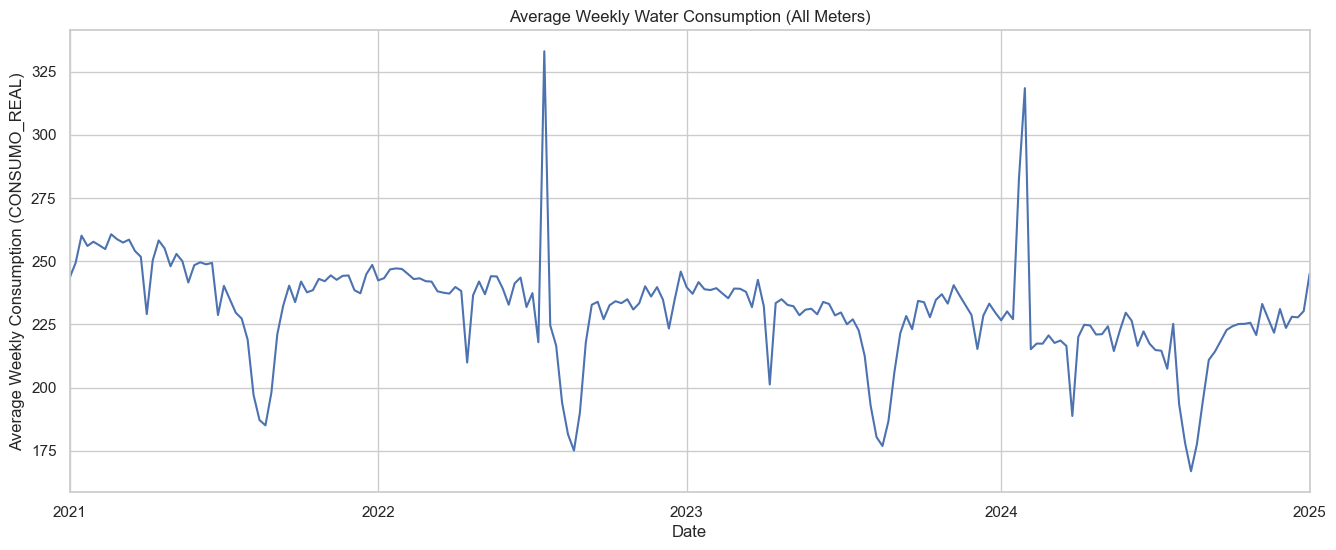

In [24]:
# --- Time-Series Analysis ---

# To make time-series plotting easier, let's set the FECHA as the index.
# We'll use our 'df_plot' DataFrame for this.
df_time = df_plot.set_index('FECHA')

# Calculate the mean consumption for each day
# 'D' stands for 'Day'
daily_avg_consumption = df_time['CONSUMO_REAL'].resample('D').mean()

# A daily plot might still be noisy, let's resample to 'Weekly'
# 'W' stands for 'Week'
weekly_avg_consumption = df_time['CONSUMO_REAL'].resample('W').mean()

# Plot the weekly average consumption
plt.figure(figsize=(16, 6))
weekly_avg_consumption.plot()
plt.title('Average Weekly Water Consumption (All Meters)')
plt.xlabel('Date')
plt.ylabel('Average Weekly Consumption (CONSUMO_REAL)')
plt.show()

**TIME SERIES BY USER TYPE**


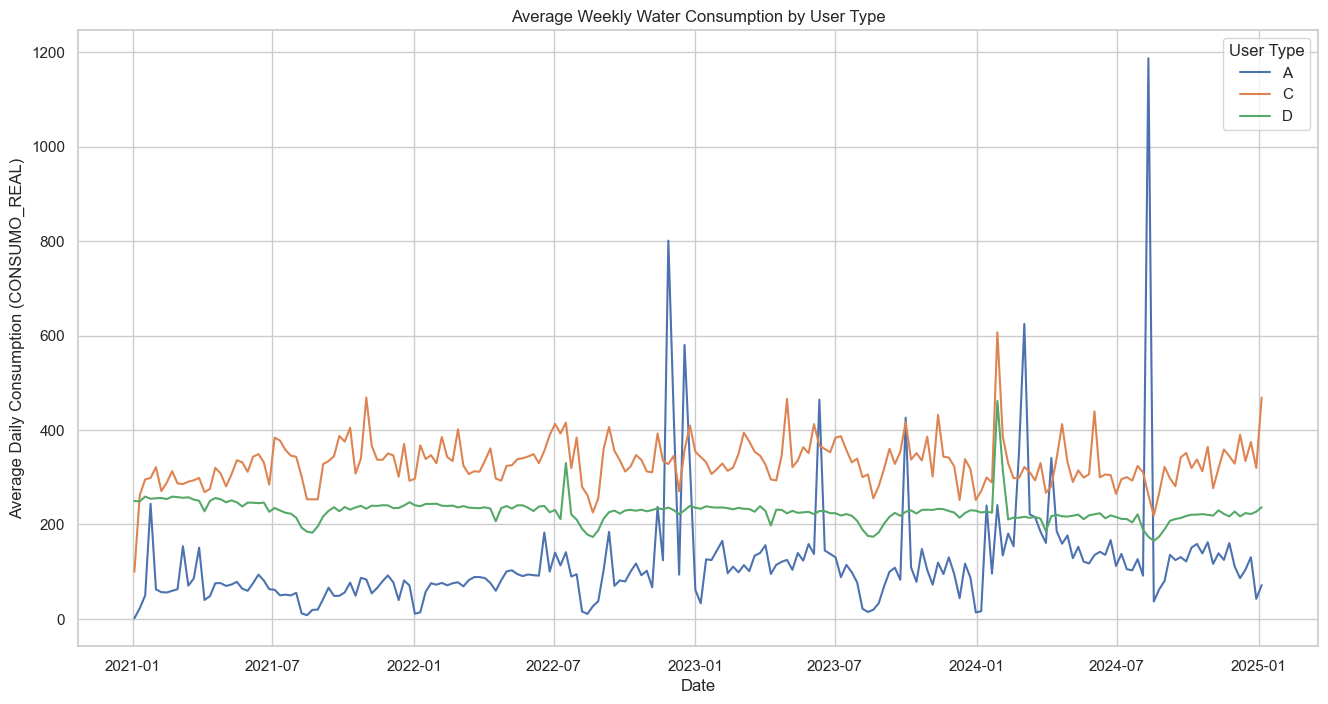

In [25]:
# --- Time-Series by User Type ---

# We'll use our 'df_plot' DataFrame, which still has the 'FECHA' column
# We will group by both date and user type, then get the mean

# Group by User Type and Date, then calculate the mean consumption
daily_avg_by_user = df_plot.groupby(
    ['US_AIGUA_GEST', pd.Grouper(key='FECHA', freq='D')]
)['CONSUMO_REAL'].mean().reset_index()

# Resample to weekly for a smoother plot
weekly_avg_by_user = daily_avg_by_user.groupby(
    ['US_AIGUA_GEST', pd.Grouper(key='FECHA', freq='W')]
)['CONSUMO_REAL'].mean().reset_index()

# Plot all three user types on one chart
plt.figure(figsize=(16, 8))
sns.lineplot(
    data=weekly_avg_by_user, 
    x='FECHA', 
    y='CONSUMO_REAL', 
    hue='US_AIGUA_GEST' # This creates a different colored line for each user type
)
plt.title('Average Weekly Water Consumption by User Type')
plt.xlabel('Date')
plt.ylabel('Average Daily Consumption (CONSUMO_REAL)')
plt.legend(title='User Type')
plt.show()

### Insights: Consumption Over Time by User Type

This plot is crucial. It deconstructs the previous aggregate time-series and shows *which* user group is responsible for *which* pattern.

* **Group C (Orange):** This group has the **highest average consumption** (300-400) and is **extremely volatile**, with sharp, frequent weekly or operational peaks and valleys. This strongly supports the idea that this is the "Commercial" or "Industrial" group.

* **Group D (Green):** This group is the **most stable**. It forms a predictable baseline around 225-250 and shows almost no seasonality or volatility. This is likely the "Domestic" user base, whose average consumption (when aggregated) is very consistent.

* **Group A (Blue):** This group has the **lowest average consumption** (around 100). Most importantly, this group is **entirely responsible for the massive, system-wide spikes** we saw in the previous plot (e.g., in mid-2022 and early 2024). This is a critical insight: those aren't "system" anomalies, they are "Group A" anomalies.

### Next Step: Zooming in to a Single Meter

This is a great macro-level view. Now, to get closer to your goal of predicting failures, we need to zoom in to the micro-level (a single meter).

Our analysis shows Group A is the most anomalous. A great next step is to pick one single meter from Group A and look at its personal consumption history.

This will help us answer:

Did all Group A meters spike at that time (suggesting a data error or real-world event)?

Or did one or two meters just go haywire (suggesting a meter failure)?

Let's find all meters in Group A, pick one, and plot its individual time series.

Plotting the history for a single 'Group A' meter: 7HSRPK37LMZXP6CU


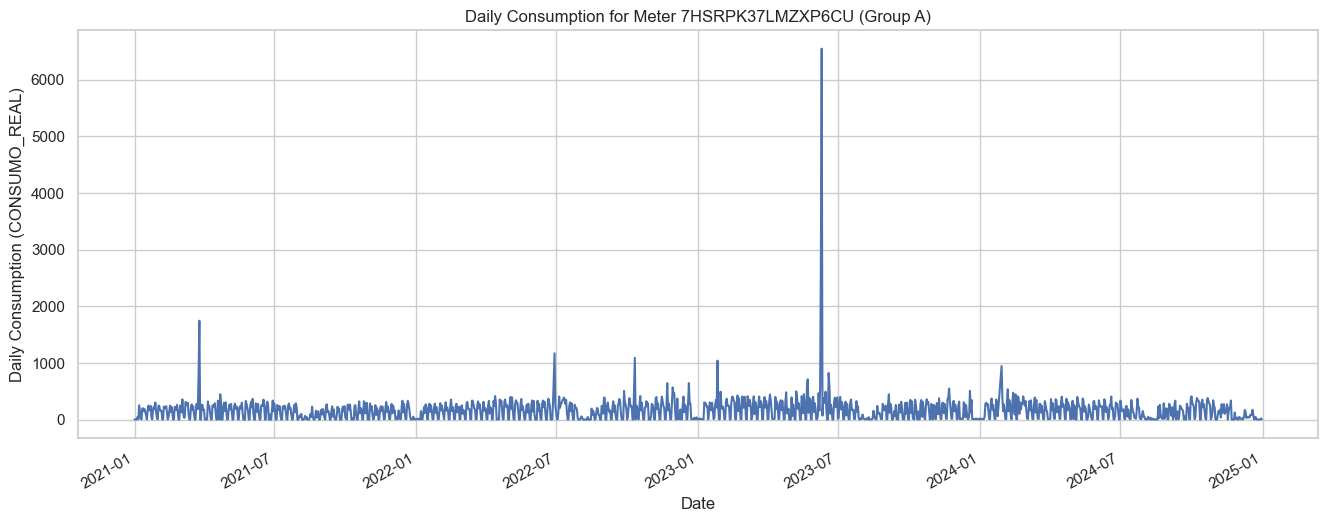

In [26]:
# --- Analysis of a Single Meter (Micro-View) ---

# 1. Get a list of all unique POLIZAs that belong to User Type 'A'
type_a_polizas = df_plot[df_plot['US_AIGUA_GEST'] == 'A']['POLIZA_SUMINISTRO'].unique()

if len(type_a_polizas) > 0:
    # 2. Pick one example POLIZA
    example_poliza_id = type_a_polizas[0]
    print(f"Plotting the history for a single 'Group A' meter: {example_poliza_id}")

    # 3. Filter the DataFrame for only this meter's data
    single_meter_df = df_plot[
        df_plot['POLIZA_SUMINISTRO'] == example_poliza_id
    ].set_index('FECHA')
    
    # 4. Plot its daily consumption
    plt.figure(figsize=(16, 6))
    single_meter_df['CONSUMO_REAL'].plot()
    plt.title(f'Daily Consumption for Meter {example_poliza_id} (Group A)')
    plt.xlabel('Date')
    plt.ylabel('Daily Consumption (CONSUMO_REAL)')
    plt.show()

else:
    print("No meters found for User Type 'A'.")

### Insights: Single Meter Time Series (Group A)

This plot of a single "Group A" meter (7HSRPK37LMZXP6CU) is a textbook example of the anomalies we are looking for.

* **Baseline vs. Spikes:** The meter has a consistent, low baseline consumption (mostly 0-250 units). However, this baseline is interrupted by sudden, erratic, and extremely high one-day spikes.

* **Failure Signature:** These spikes are a classic "anomaly" pattern. They don't look like normal seasonal use. They are abrupt, short-lived, and far outside the normal range, which could signal a failing sensor, a temporary data-read error, or a real-world event like a burst pipe.

* **Connecting to the Macro View:** The *enormous* spike (over 6,000 units) in mid-2023 on *this single meter* directly corresponds to the massive spike we saw in the "Average Weekly Consumption for Group A" plot. This is a critical finding: it suggests the "Group A" anomalies are not a system-wide error but are instead driven by a few individual meters experiencing extreme events.

----------------------------------------------------------------------------------------------------------------------------------------

## Next Step: Analysis by Meter Diameter

We've now analyzed by **Brand** (`MARCA_COMP`) and **User Type** (`US_A_GEST`). The final piece of the "grouping" analysis your team suggested was by **Diameter** (`DIAM_COMP`).

This is a key physical attribute. We'd expect meters with a larger diameter (which are built for higher flow) to have higher consumption.

Let's use our `df_plot` to create one more boxplot.

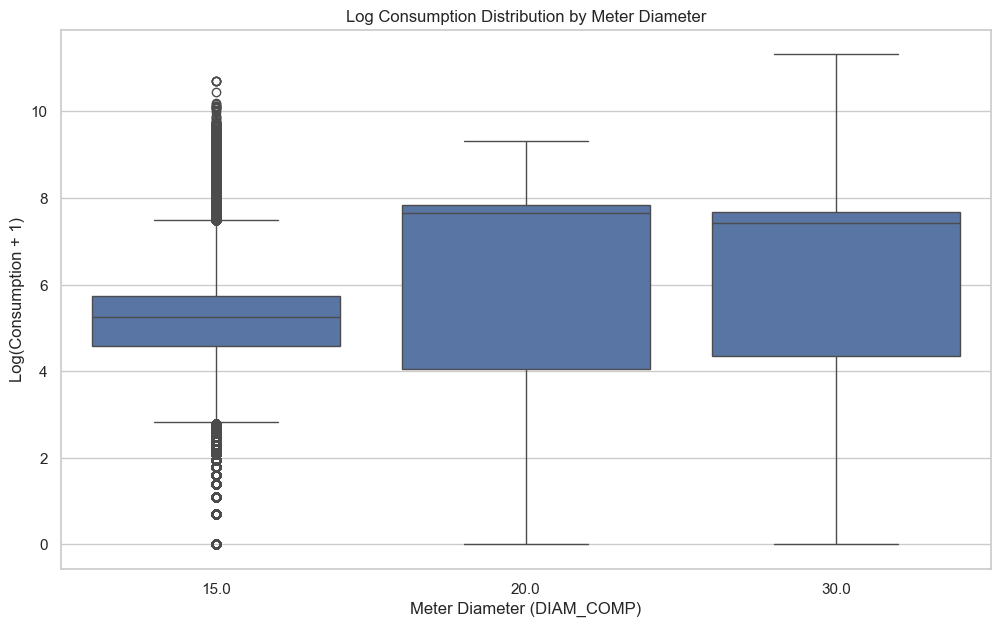

In [27]:
# Plot CONSUMO_LOG grouped by DIAM_COMP
plt.figure(figsize=(12, 7))
sns.boxplot(
    data=df_plot, 
    x='DIAM_COMP', 
    y='CONSUMO_LOG'
)
plt.title('Log Consumption Distribution by Meter Diameter')
plt.xlabel('Meter Diameter (DIAM_COMP)')
plt.ylabel('Log(Consumption + 1)')
plt.show()

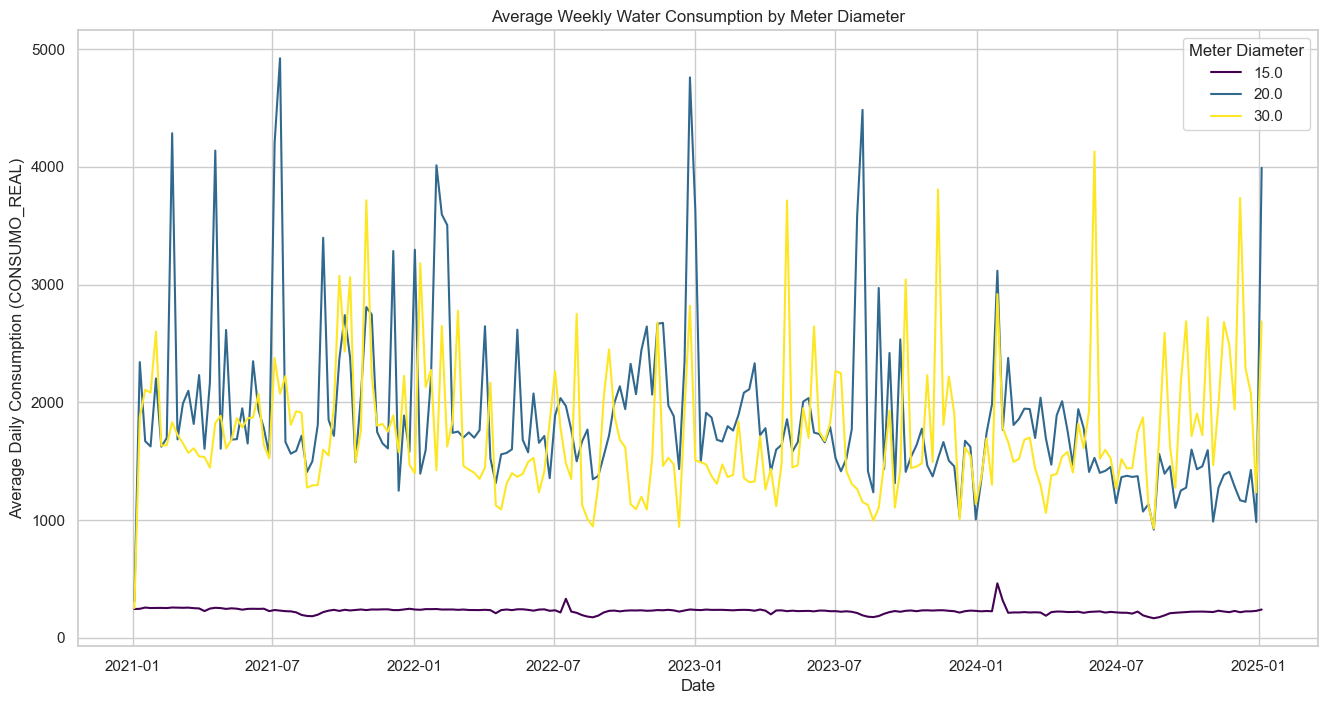

In [28]:
# --- Time-Series by Meter Diameter ---

# We will group by both date and meter diameter, then get the mean

# Group by DIAM_COMP and Date, then calculate the mean consumption
daily_avg_by_diam = df_plot.groupby(
    ['DIAM_COMP', pd.Grouper(key='FECHA', freq='D')]
)['CONSUMO_REAL'].mean().reset_index()

# Resample to weekly for a smoother plot
weekly_avg_by_diam = daily_avg_by_diam.groupby(
    ['DIAM_COMP', pd.Grouper(key='FECHA', freq='W')]
)['CONSUMO_REAL'].mean().reset_index()

# Plot all three diameter types on one chart
plt.figure(figsize=(16, 8))
sns.lineplot(
    data=weekly_avg_by_diam, 
    x='FECHA', 
    y='CONSUMO_REAL', 
    hue='DIAM_COMP', # This creates a different colored line for each diameter
    palette='viridis' # Use a different color palette
)
plt.title('Average Weekly Water Consumption by Meter Diameter')
plt.xlabel('Date')
plt.ylabel('Average Daily Consumption (CONSUMO_REAL)')
plt.legend(title='Meter Diameter')
plt.show()

### Insights: Consumption Over Time by Meter Diameter

This time-series plot shows a clear separation in behavior based on the meter's physical diameter.

* **15.0mm (Green Line):** This group has the **most stable** and lowest average consumption, forming a predictable baseline around 225-250. This strongly aligns with the "User Type D" (Domestic) group and confirms 15.0mm as the standard residential meter size.

* **30.0mm (Purple Line):** This group has the **highest average consumption** and is **highly volatile**, aligning perfectly with the "User Type C" (Commercial/Industrial) group.

* **20.0mm (Yellow Line):** This group has the **lowest average consumption** and is responsible for the **massive system-wide spikes**. This is the same pattern we saw with "User Type A".

**Key Takeaway:** We have found a powerful link. The anomalous spikes in the dataset are almost entirely isolated to `User Type A` and `Diameter 20.0mm` meters. This is a critical insight for building your failure prediction model, as it tells you *exactly* which group of meters is the most problematic and worthy of investigation.

## Detailed Anomaly Analysis by Groups

Now we'll perform a detailed analysis of anomalies by grouping the data by brand, model, and diameter. For each group, we'll:

1. Define anomalies using different statistical approaches
2. Check for normality and consider transformations
3. Analyze monthly patterns in anomalies
4. Compare anomaly distributions across brands/models

C:\Users\alber\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 4746341.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\alber\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11635.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\alber\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 62178.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\alber\AppData\

Anomaly Statistics by Group (Brand and Diameter):


C:\Users\alber\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 719624.
  res = hypotest_fun_out(*samples, **kwds)


total_records  std_anomalies  iqr_anomalies  \
5557SZ47QZAZ56EQ 15.0        4746341          36620         137199   
                 20.0           1454             32             36   
                 30.0          11635            101            319   
7WZSCJKXGT7J2Q5E 15.0          62178            767           1399   
OKV4SQYX72EBODPA 15.0         258687           2997           8978   
R7GO7PZAU5F6DHFH 15.0         719624           5997          21481   

                       zscore_anomalies  \
5557SZ47QZAZ56EQ 15.0            117994   
                 20.0                57   
                 30.0               334   
7WZSCJKXGT7J2Q5E 15.0              1234   
OKV4SQYX72EBODPA 15.0              9050   
R7GO7PZAU5F6DHFH 15.0             19070   

                                                    monthly_distribution  
5557SZ47QZAZ56EQ 15.0  {1: 4513, 2: 2598, 3: 2682, 4: 2642, 5: 2692, ...  
                 20.0  {1: 4, 2: 4, 4: 4, 7: 5, 8: 3, 9: 4, 10: 1, 11...  
                 30.0  {1: 9, 2: 7, 4: 6, 5: 7, 6: 6, 7: 10, 8: 3, 9:...  
7WZSCJKXGT7J2Q5E 15.0  {1: 65, 2: 47, 3: 49, 4: 65, 5: 74, 6: 62, 7: ...  
OKV4SQYX72EBODPA 15.0  {1: 252, 2: 176, 3: 210, 4: 227, 5: 232, 6: 23...  
R7GO7PZAU5F6DHFH 15.0  {1: 791, 2: 415, 3: 398, 4: 475, 5: 446, 6: 50...

<Figure size 1500x800 with 0 Axes>

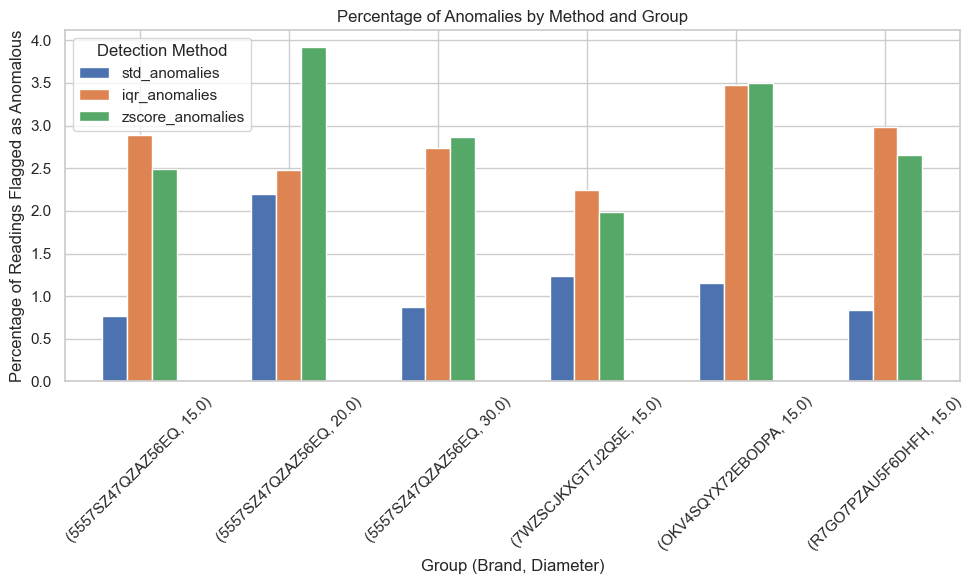

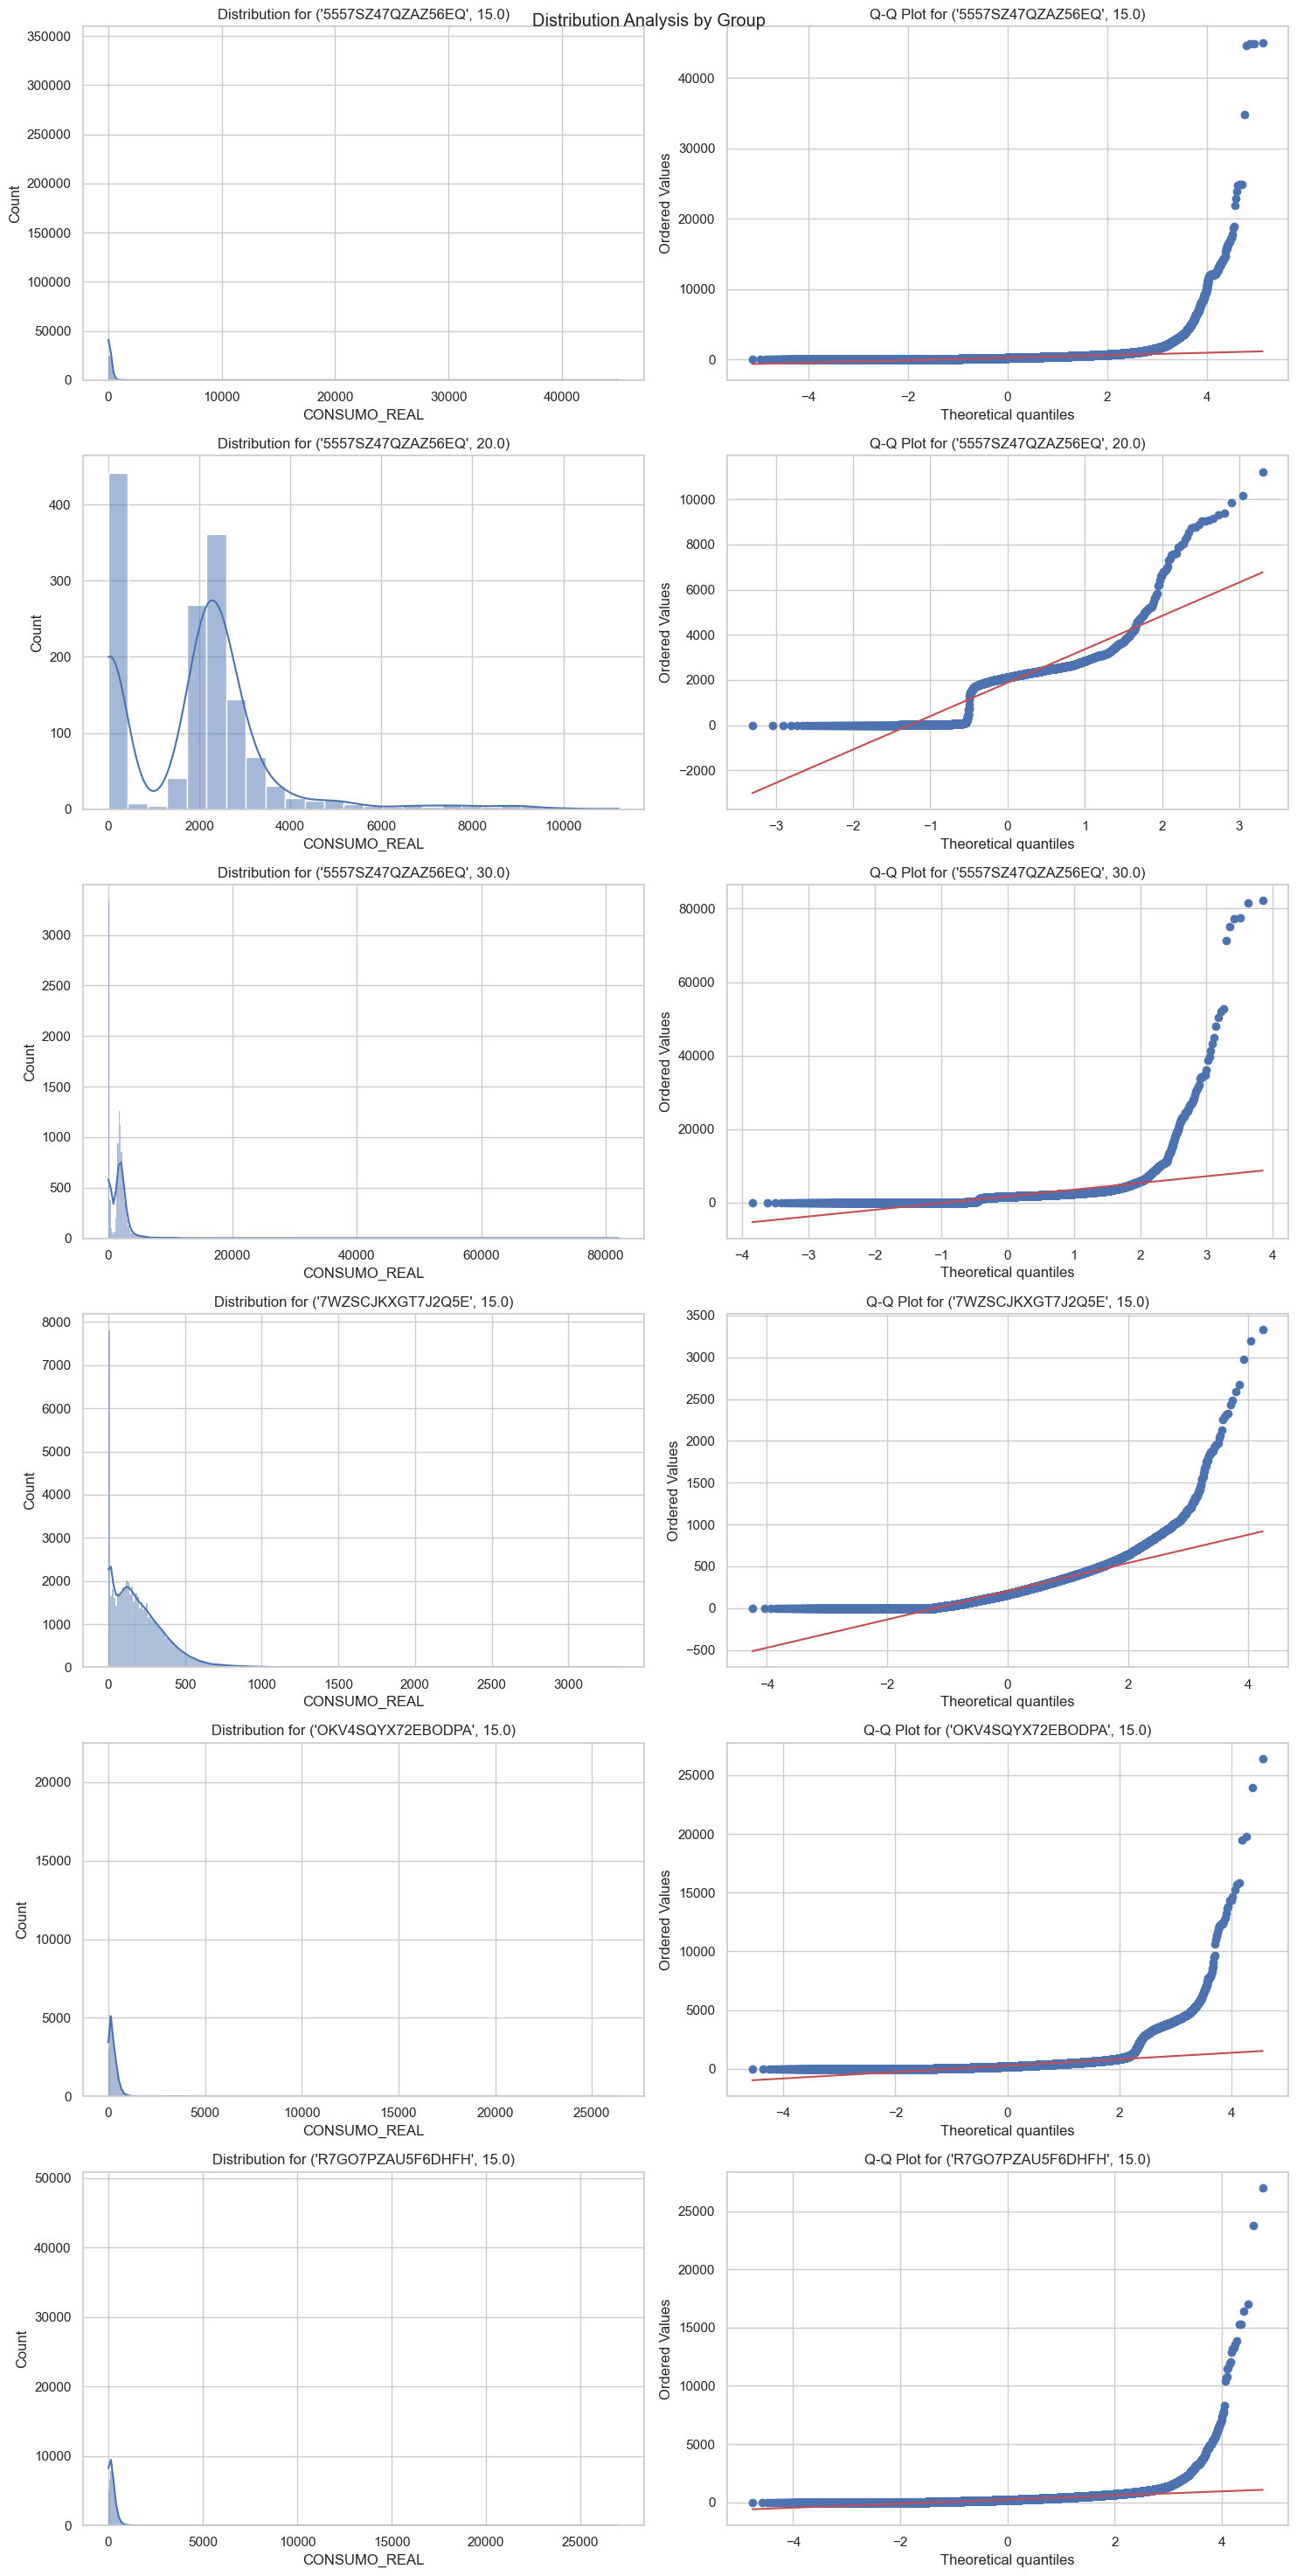

In [29]:
from scipy import stats
# First, let's create a function to identify anomalies using different methods
def identify_anomalies(group_data, n_std=3):
    """
    Identify anomalies in a group using multiple methods:
    1. Standard deviation method (n_std deviations from mean)
    2. IQR method (1.5 * IQR from quartiles)
    3. Modified Z-score method
    
    Returns a DataFrame with boolean columns for each method
    """
    # Calculate statistics
    mean = group_data['CONSUMO_REAL'].mean()
    std = group_data['CONSUMO_REAL'].std()
    Q1 = group_data['CONSUMO_REAL'].quantile(0.25)
    Q3 = group_data['CONSUMO_REAL'].quantile(0.75)
    IQR = Q3 - Q1
    
    # Calculate median absolute deviation for modified Z-score
    median = group_data['CONSUMO_REAL'].median()
    mad = np.median(np.abs(group_data['CONSUMO_REAL'] - median))
    
    # Create anomaly flags
    anomalies = pd.DataFrame({
        'std_method': (np.abs(group_data['CONSUMO_REAL'] - mean) > n_std * std),
        'iqr_method': ((group_data['CONSUMO_REAL'] < (Q1 - 1.5 * IQR)) | 
                      (group_data['CONSUMO_REAL'] > (Q3 + 1.5 * IQR))),
        'zscore_method': (np.abs(0.6745 * (group_data['CONSUMO_REAL'] - median) / mad) > n_std)
    })
    
    # Add month information for temporal analysis
    anomalies['month'] = group_data['FECHA'].dt.month
    
    return anomalies

# Create groups based on brand, model, and diameter
groups = df_plot.groupby(['MARCA_COMP', 'DIAM_COMP'])

# Initialize dictionaries to store results
anomaly_stats = {}
normality_tests = {}

# Process each group
for name, group in groups:
    # Get anomalies
    anomalies = identify_anomalies(group)
    
    # Store basic stats
    anomaly_stats[name] = {
        'total_records': len(group),
        'std_anomalies': anomalies['std_method'].sum(),
        'iqr_anomalies': anomalies['iqr_method'].sum(),
        'zscore_anomalies': anomalies['zscore_method'].sum(),
        'monthly_distribution': anomalies[anomalies['std_method']].groupby('month').size().to_dict()
    }
    
    # Perform Shapiro-Wilk test for normality
    _, p_value = stats.shapiro(group['CONSUMO_REAL'])
    normality_tests[name] = p_value

# Convert results to DataFrame for easier visualization
anomaly_df = pd.DataFrame.from_dict(anomaly_stats, orient='index')
# Display summary statistics for each group
print("Anomaly Statistics by Group (Brand and Diameter):")
display(anomaly_df)

# Create a visualization of anomaly percentages by group
plt.figure(figsize=(15, 8))
anomaly_percentages = anomaly_df[['std_anomalies', 'iqr_anomalies', 'zscore_anomalies']].div(anomaly_df['total_records'], axis=0) * 100

# Plot the percentages
anomaly_percentages.plot(kind='bar')
plt.title('Percentage of Anomalies by Method and Group')
plt.xlabel('Group (Brand, Diameter)')
plt.ylabel('Percentage of Readings Flagged as Anomalous')
plt.xticks(rotation=45)
plt.legend(title='Detection Method')
plt.tight_layout()
plt.show()

# Test for normality and create QQ plots for each group
fig, axes = plt.subplots(len(groups), 2, figsize=(15, 5*len(groups)))
fig.suptitle('Distribution Analysis by Group')

for i, (name, group) in enumerate(groups):
    # Histogram
    sns.histplot(data=group, x='CONSUMO_REAL', kde=True, ax=axes[i,0])
    axes[i,0].set_title(f'Distribution for {name}')
    
    # QQ Plot
    stats.probplot(group['CONSUMO_REAL'], dist="norm", plot=axes[i,1])
    axes[i,1].set_title(f'Q-Q Plot for {name}')
    
plt.tight_layout()
plt.show()


### Analyzing Monthly Patterns in Anomalies

Now let's examine if there are any seasonal patterns in when anomalies occur. We'll create a heatmap showing the distribution of anomalies by month for each group.

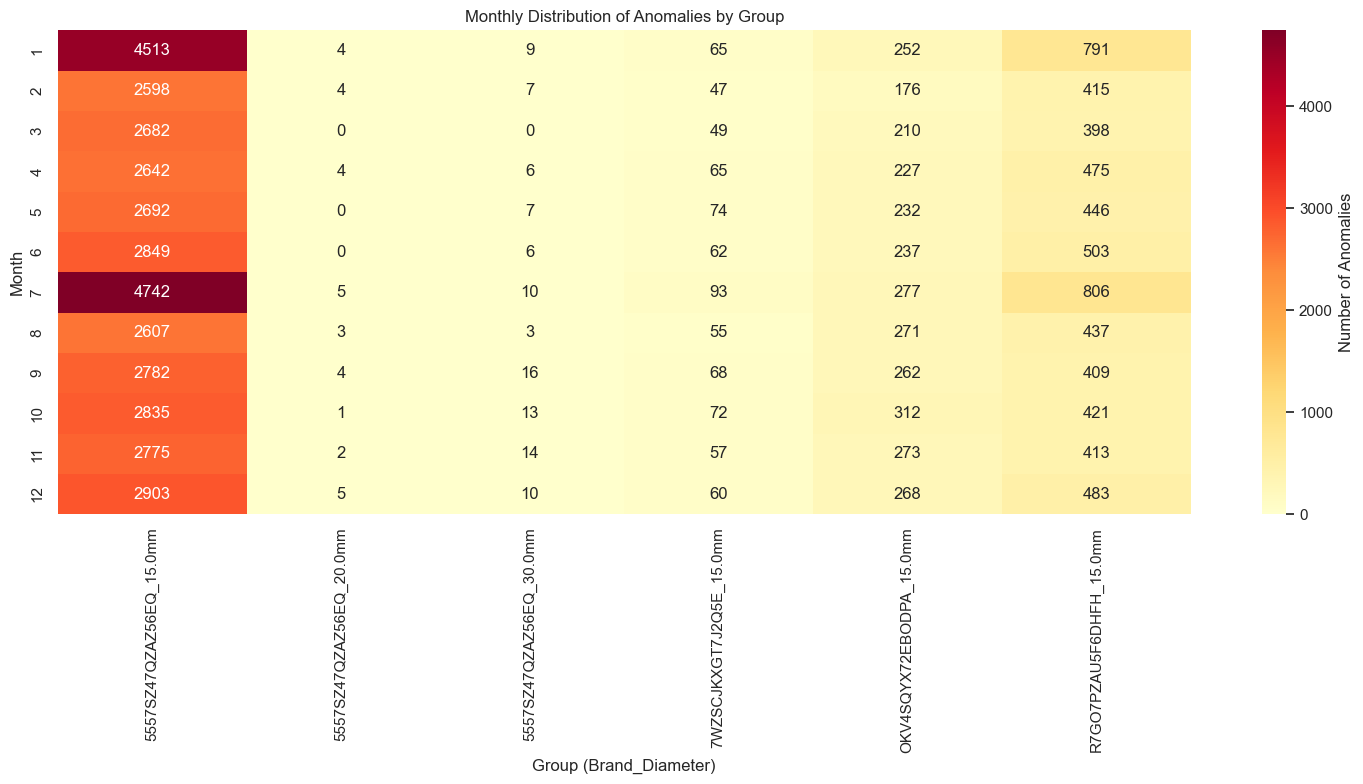

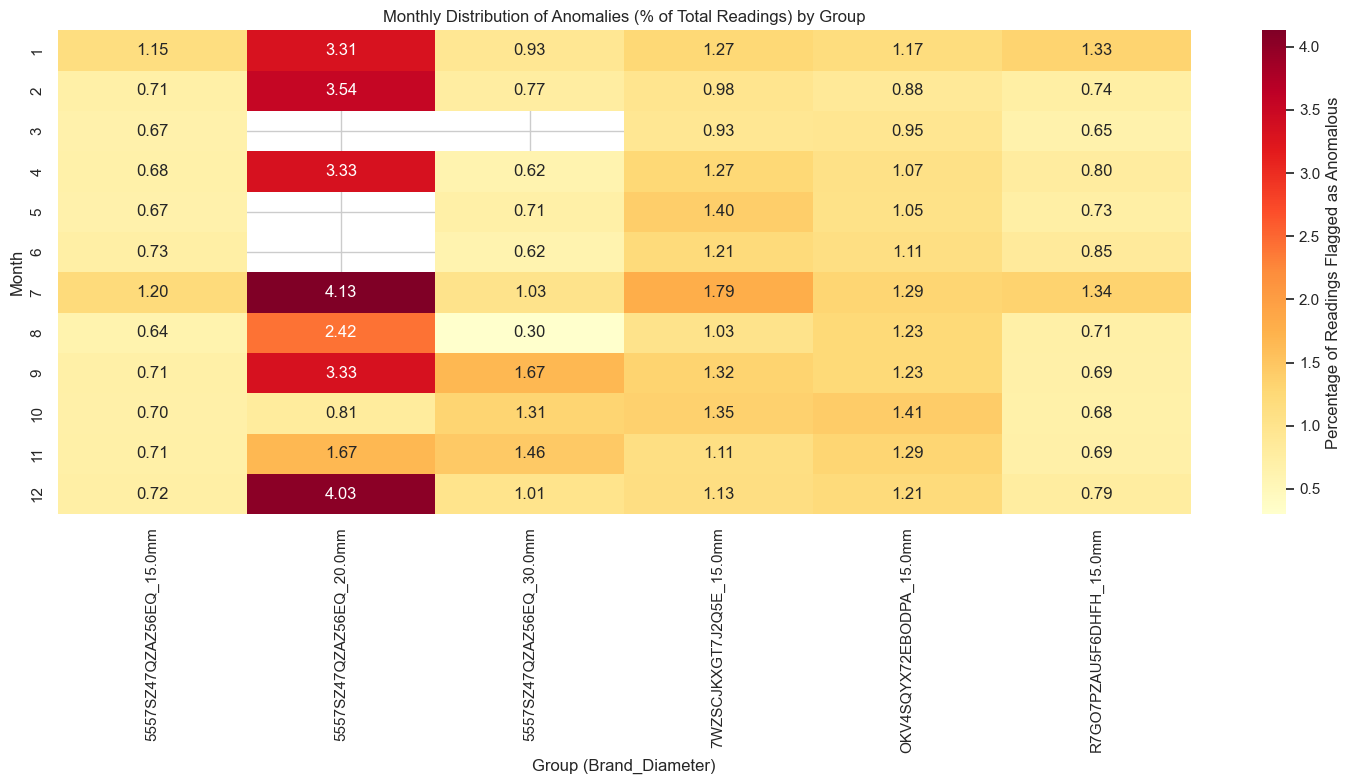

In [30]:
# Create a monthly analysis of anomalies
monthly_anomalies = pd.DataFrame(index=range(1, 13))  # months 1-12

for name, group in groups:
    anomalies = identify_anomalies(group)
    monthly_counts = anomalies[anomalies['std_method']].groupby('month').size()
    monthly_anomalies[f'{name[0]}_{name[1]}mm'] = monthly_counts

# Fill NaN values with 0 (months with no anomalies)
monthly_anomalies = monthly_anomalies.fillna(0)

# Create a heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(monthly_anomalies, 
            cmap='YlOrRd',
            annot=True,
            fmt='.0f',
            cbar_kws={'label': 'Number of Anomalies'})
plt.title('Monthly Distribution of Anomalies by Group')
plt.xlabel('Group (Brand_Diameter)')
plt.ylabel('Month')
plt.tight_layout()
plt.show()

# Calculate the percentage of anomalies relative to total readings for each month
total_readings_by_month = {}
anomaly_percentages_by_month = pd.DataFrame(index=range(1, 13))

for name, group in groups:
    # Get total readings per month for this group
    monthly_totals = group.groupby(group['FECHA'].dt.month).size()
    
    # Get anomalies for this group
    anomalies = identify_anomalies(group)
    monthly_anomaly_counts = anomalies[anomalies['std_method']].groupby('month').size()
    
    # Calculate percentage
    monthly_pct = (monthly_anomaly_counts / monthly_totals * 100).round(2)
    anomaly_percentages_by_month[f'{name[0]}_{name[1]}mm'] = monthly_pct

# Create a heatmap of percentages
plt.figure(figsize=(15, 8))
sns.heatmap(anomaly_percentages_by_month,
            cmap='YlOrRd',
            annot=True,
            fmt='.2f',
            cbar_kws={'label': 'Percentage of Readings Flagged as Anomalous'})
plt.title('Monthly Distribution of Anomalies (% of Total Readings) by Group')
plt.xlabel('Group (Brand_Diameter)')
plt.ylabel('Month')
plt.tight_layout()
plt.show()

### Investigation of Data Transformations

Since we've observed that the consumption data is not normally distributed, let's investigate different transformations to see if they help normalize the data. This is important because many statistical methods assume normality.
# Let's try different transformations and test for normality

C:\Users\alber\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 4446810.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\alber\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 4446810.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\alber\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\stats\_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 11042.
  res = hypotest_fun_out(*samples, **kwds)
C:\Users\alber\AppDat

,Original p-value,Log p-value,Sqrt p-value,Box-Cox p-value,Box-Cox lambda
5557SZ47QZAZ56EQ_15.0mm,2.037851e-211,3.398442e-166,5.455125e-127,2.065267e-104,0.359863
5557SZ47QZAZ56EQ_20.0mm,8.148589e-37,2.063968e-42,3.248981e-35,1.443914e-36,0.408999
5557SZ47QZAZ56EQ_30.0mm,4.823212e-107,1.175441e-81,1.256442e-76,2.301219e-71,0.316164
7WZSCJKXGT7J2Q5E_15.0mm,2.005740e-106,3.130729e-98,5.900939e-45,1.508245e-34,0.388855
OKV4SQYX72EBODPA_15.0mm,1.271752e-187,9.230998e-119,5.266234e-141,1.417641e-96,0.193325
R7GO7PZAU5F6DHFH_15.0mm,4.637626e-186,5.407348e-150,1.721302e-103,7.072555e-83,0.369678


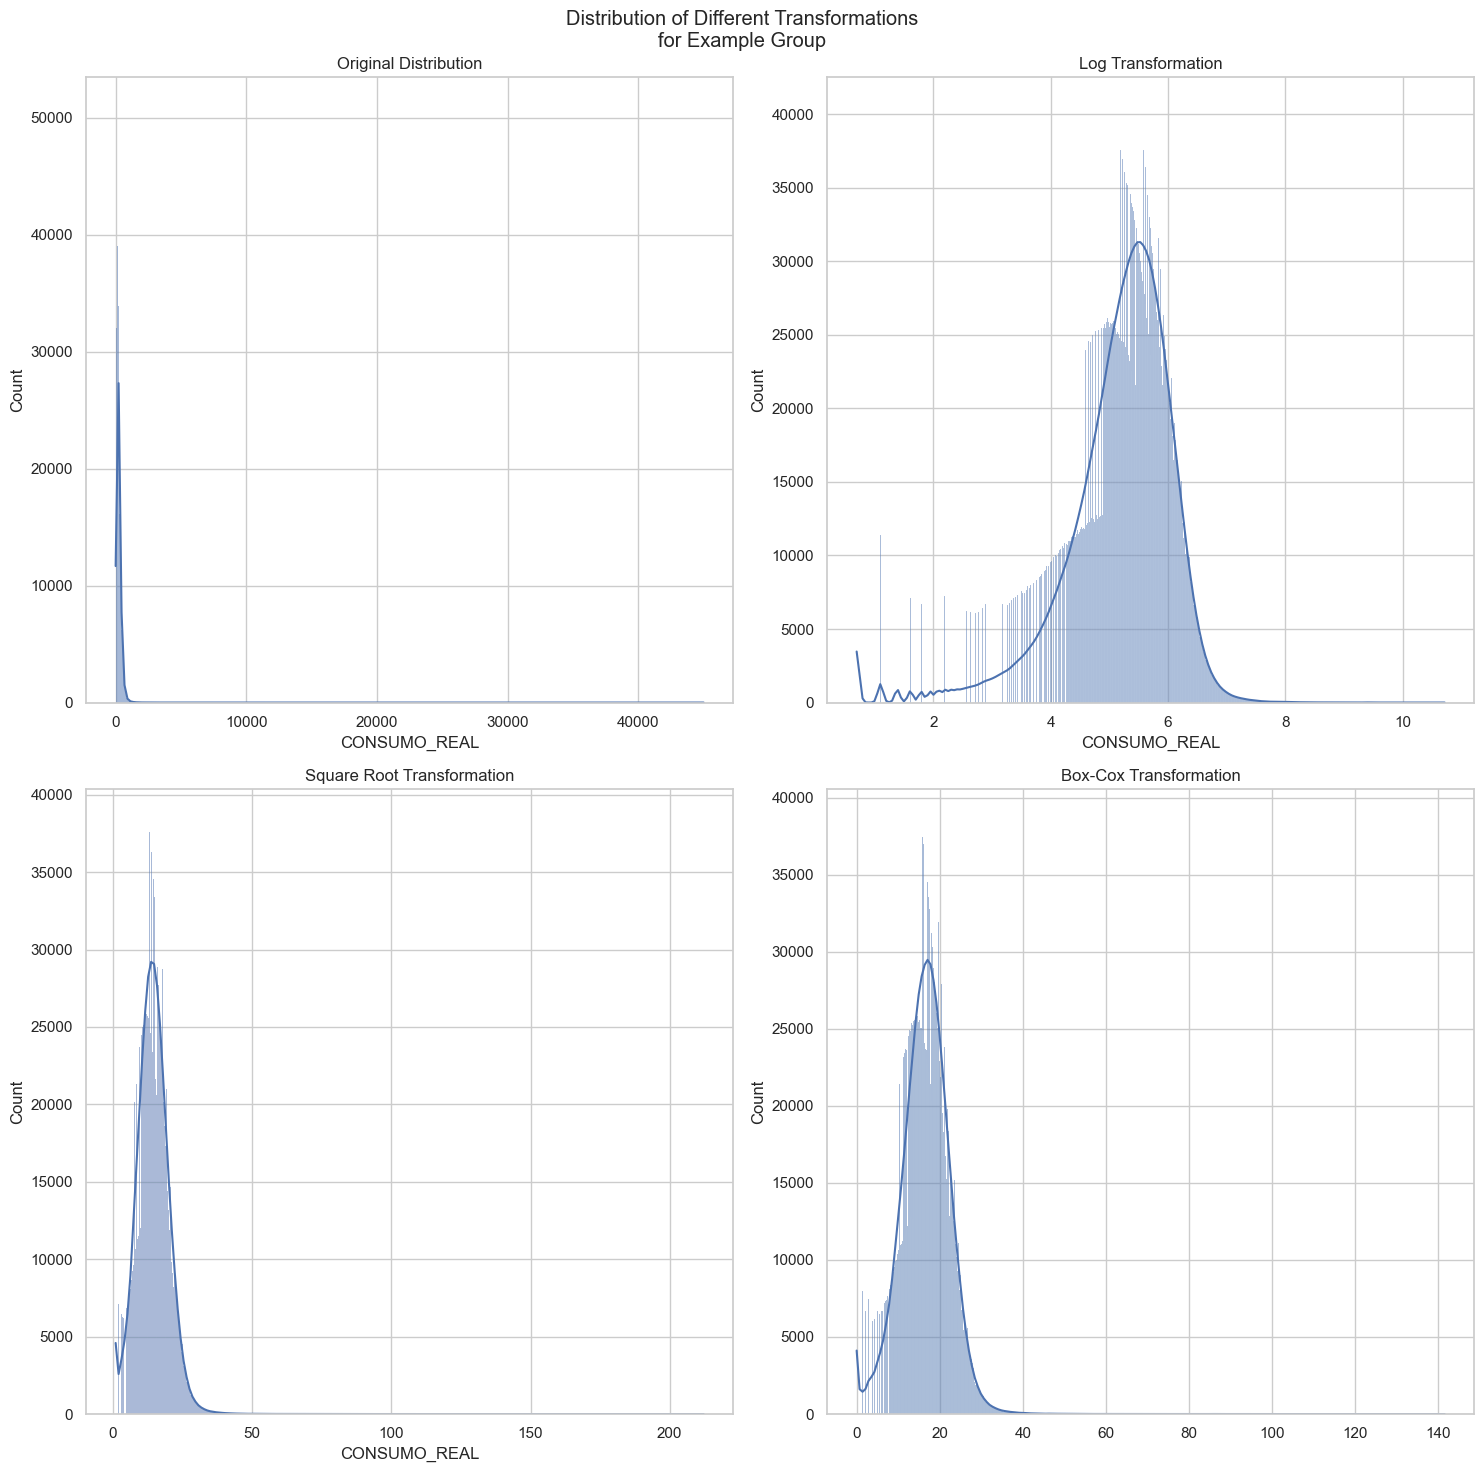

In [31]:

def test_transformations(data):
    """Test different transformations and their effect on normality"""
    
    # Original data
    _, p_orig = stats.shapiro(data)
    
    # Log transformation (already have CONSUMO_LOG)
    log_data = np.log1p(data)
    _, p_log = stats.shapiro(log_data)
    
    # Square root transformation
    sqrt_data = np.sqrt(data)
    _, p_sqrt = stats.shapiro(sqrt_data)
    
    # Box-Cox transformation
    boxcox_data, lambda_param = stats.boxcox(data + 1)  # Add 1 to handle zeros
    _, p_boxcox = stats.shapiro(boxcox_data)
    
    return pd.Series({
        'Original p-value': p_orig,
        'Log p-value': p_log,
        'Sqrt p-value': p_sqrt,
        'Box-Cox p-value': p_boxcox,
        'Box-Cox lambda': lambda_param
    })

# Test transformations for each group
transformation_results = {}

for name, group in groups:
    # Only test positive values
    positive_data = group['CONSUMO_REAL'][group['CONSUMO_REAL'] > 0]
    if len(positive_data) > 0:
        transformation_results[f'{name[0]}_{name[1]}mm'] = test_transformations(positive_data)

# Convert results to DataFrame
transform_df = pd.DataFrame(transformation_results).T
display(transform_df)

# Visualize the effect of transformations for one example group
example_group = next(iter(groups))[1]  # Take the first group
positive_data = example_group['CONSUMO_REAL'][example_group['CONSUMO_REAL'] > 0]

if len(positive_data) > 0:
    # Create subplots for different transformations
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    fig.suptitle('Distribution of Different Transformations\nfor Example Group')
    
    # Original data
    sns.histplot(positive_data, kde=True, ax=axes[0,0])
    axes[0,0].set_title('Original Distribution')
    
    # Log transformation
    sns.histplot(np.log1p(positive_data), kde=True, ax=axes[0,1])
    axes[0,1].set_title('Log Transformation')
    
    # Square root transformation
    sns.histplot(np.sqrt(positive_data), kde=True, ax=axes[1,0])
    axes[1,0].set_title('Square Root Transformation')
    
    # Box-Cox transformation
    boxcox_data, _ = stats.boxcox(positive_data)
    sns.histplot(boxcox_data, kde=True, ax=axes[1,1])
    axes[1,1].set_title('Box-Cox Transformation')
    
    plt.tight_layout()
    plt.show()

,MARCA_COMP,CODI_MODEL,DIAM_COMP,total_readings,total_anomalies,anomaly_rate
0,OKV4SQYX72EBODPA,27.0,15.0,136560,5576,4.083187
1,5557SZ47QZAZ56EQ,63.0,15.0,33788,1338,3.959986
2,5557SZ47QZAZ56EQ,48.0,20.0,1454,57,3.920220
3,OKV4SQYX72EBODPA,21.0,15.0,46532,1807,3.883349
4,R7GO7PZAU5F6DHFH,2.0,15.0,700722,21099,3.011037
5,5557SZ47QZAZ56EQ,31.0,15.0,4712553,136196,2.890068
6,5557SZ47QZAZ56EQ,23.0,30.0,11635,334,2.870649
7,7WZSCJKXGT7J2Q5E,66.0,15.0,31966,749,2.343115
8,OKV4SQYX72EBODPA,46.0,15.0,75595,1733,2.292480
9,R7GO7PZAU5F6DHFH,4.0,15.0,18902,396,2.095016


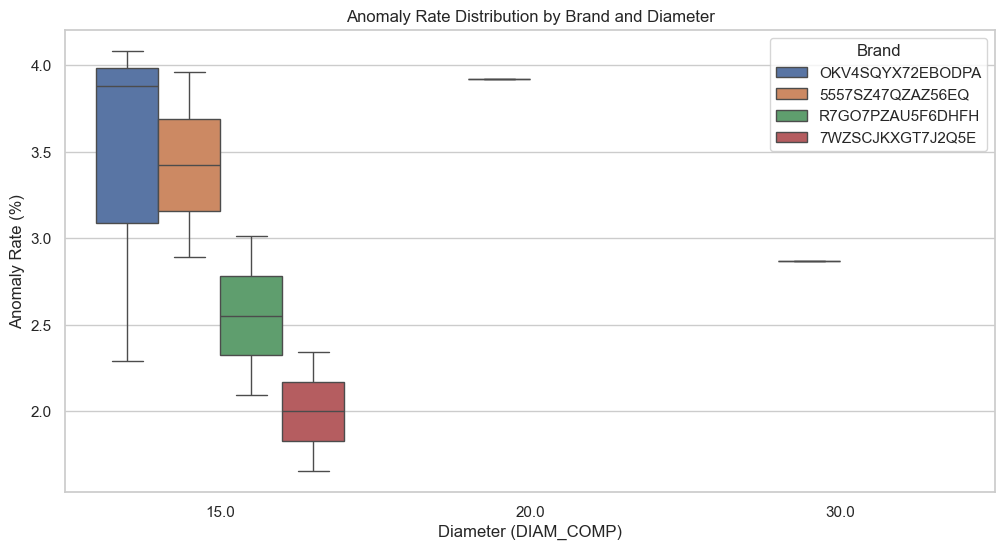

In [36]:
# Extend grouping to include model, as per instructor's request
groups = df_plot.groupby(['MARCA_COMP', 'CODI_MODEL', 'DIAM_COMP'])

summary_rows = []

for name, group in groups:
    anomalies = identify_anomalies(group)
    
    # Combine all three anomaly detection methods
    combined = anomalies[['std_method', 'iqr_method', 'zscore_method']].any(axis=1)
    
    total_readings = len(group)
    total_anomalies = combined.sum()
    anomaly_rate = 100 * total_anomalies / total_readings if total_readings > 0 else 0
    
    summary_rows.append({
        'MARCA_COMP': name[0],
        'CODI_MODEL': name[1],
        'DIAM_COMP': name[2],
        'total_readings': total_readings,
        'total_anomalies': total_anomalies,
        'anomaly_rate': anomaly_rate
    })

summary = (
    pd.DataFrame(summary_rows)
    .sort_values('anomaly_rate', ascending=False)
    .reset_index(drop=True)
)

# Display top 10 groups
display(summary.head(10))

# Boxplot comparing anomaly rate across diameters and brands
plt.figure(figsize=(12,6))
sns.boxplot(
    data=summary,
    x='DIAM_COMP',
    y='anomaly_rate',
    hue='MARCA_COMP'
)
plt.title('Anomaly Rate Distribution by Brand and Diameter')
plt.ylabel('Anomaly Rate (%)')
plt.xlabel('Diameter (DIAM_COMP)')
plt.legend(title='Brand')
plt.show()




In [38]:
for name, group in df_plot.groupby(['MARCA_COMP', 'CODI_MODEL', 'DIAM_COMP']):
    anomalies = identify_anomalies(group)
    
    # Combine anomaly flags
    combined = anomalies[['std_method', 'iqr_method', 'zscore_method']].any(axis=1)
    
    # Compute central tendency
    median_value = group['CONSUMO_REAL'].median()
    
    # Classify anomaly type
    anomaly_type = np.where(
        group['CONSUMO_REAL'] < median_value, 'Low consumption', 'High consumption'
    )
    
    summary = pd.Series(anomaly_type[combined], dtype='category').value_counts()
    print(f"{name}:")
    print(summary)
    print()


('5557SZ47QZAZ56EQ', 23.0, 30.0):
High consumption    334
Name: count, dtype: int64

('5557SZ47QZAZ56EQ', 31.0, 15.0):
High consumption    136196
Name: count, dtype: int64

('5557SZ47QZAZ56EQ', 48.0, 20.0):
High consumption    57
Name: count, dtype: int64

('5557SZ47QZAZ56EQ', 63.0, 15.0):
High consumption    1338
Name: count, dtype: int64

('7WZSCJKXGT7J2Q5E', 66.0, 15.0):
High consumption    749
Name: count, dtype: int64

('7WZSCJKXGT7J2Q5E', 73.0, 15.0):
High consumption    500
Name: count, dtype: int64

('OKV4SQYX72EBODPA', 21.0, 15.0):
High consumption    1807
Name: count, dtype: int64

('OKV4SQYX72EBODPA', 27.0, 15.0):
High consumption    5576
Name: count, dtype: int64

('OKV4SQYX72EBODPA', 46.0, 15.0):
High consumption    1733
Name: count, dtype: int64

('R7GO7PZAU5F6DHFH', 2.0, 15.0):
High consumption    21099
Name: count, dtype: int64

('R7GO7PZAU5F6DHFH', 4.0, 15.0):
High consumption    396
Name: count, dtype: int64



In [44]:
import numpy as np
import pandas as pd

# Create a copy to avoid modifying df_plot directly
df_anomalies = []

for name, group in df_plot.groupby(['MARCA_COMP', 'CODI_MODEL', 'DIAM_COMP']):
    anomalies = identify_anomalies(group)
    combined = anomalies[['std_method', 'iqr_method', 'zscore_method']].any(axis=1)
    
    # Classify direction (relative to median)
    median_val = group['CONSUMO_REAL'].median()
    direction = np.where(
        group['CONSUMO_REAL'] < median_val, 'Low', 'High'
    )
    
    temp = pd.DataFrame({
        'MARCA_COMP': name[0],
        'CODI_MODEL': name[1],
        'DIAM_COMP': name[2],
        'CONSUMO_REAL': group['CONSUMO_REAL'],
        'is_anomaly': combined,
        'anomaly_direction': direction
    })
    
    df_anomalies.append(temp)

df_anomalies = pd.concat(df_anomalies, ignore_index=True)


In [45]:
# Aggregate counts
anomaly_summary = (
    df_anomalies.groupby(['MARCA_COMP', 'CODI_MODEL', 'DIAM_COMP', 'anomaly_direction'])
    .agg(total=('CONSUMO_REAL', 'count'),
         anomalies=('is_anomaly', 'sum'))
    .reset_index()
)

# Compute anomaly rates
anomaly_summary['anomaly_rate'] = 100 * anomaly_summary['anomalies'] / anomaly_summary['total']
display(anomaly_summary.sort_values('anomaly_rate', ascending=False).head(10))


,MARCA_COMP,CODI_MODEL,DIAM_COMP,anomaly_direction,total,anomalies,anomaly_rate
14,OKV4SQYX72EBODPA,27.0,15.0,High,68506,5576,8.139433
6,5557SZ47QZAZ56EQ,63.0,15.0,High,16911,1338,7.912010
4,5557SZ47QZAZ56EQ,48.0,20.0,High,727,57,7.840440
12,OKV4SQYX72EBODPA,21.0,15.0,High,23299,1807,7.755698
18,R7GO7PZAU5F6DHFH,2.0,15.0,High,350829,21099,6.014041
2,5557SZ47QZAZ56EQ,31.0,15.0,High,2364311,136196,5.760494
0,5557SZ47QZAZ56EQ,23.0,30.0,High,5825,334,5.733906
8,7WZSCJKXGT7J2Q5E,66.0,15.0,High,16046,749,4.667830
16,OKV4SQYX72EBODPA,46.0,15.0,High,37837,1733,4.580173
20,R7GO7PZAU5F6DHFH,4.0,15.0,High,9470,396,4.181626


In [48]:
df_anomalies['month'] = df_plot['FECHA'].dt.month


In [49]:
# Monthly aggregation
monthly_anomalies = (
    df_anomalies.groupby(['MARCA_COMP', 'CODI_MODEL', 'DIAM_COMP', 'month'])
    .agg(total=('CONSUMO_REAL', 'count'),
         anomalies=('is_anomaly', 'sum'))
    .reset_index()
)

monthly_anomalies['anomaly_rate'] = 100 * monthly_anomalies['anomalies'] / monthly_anomalies['total']
display(monthly_anomalies.head())


,MARCA_COMP,CODI_MODEL,DIAM_COMP,month,total,anomalies,anomaly_rate
0,5557SZ47QZAZ56EQ,23.0,30.0,1,966,41,4.244306
1,5557SZ47QZAZ56EQ,23.0,30.0,2,904,21,2.323009
2,5557SZ47QZAZ56EQ,23.0,30.0,3,989,6,0.606673
3,5557SZ47QZAZ56EQ,23.0,30.0,4,960,17,1.770833
4,5557SZ47QZAZ56EQ,23.0,30.0,5,992,22,2.217742


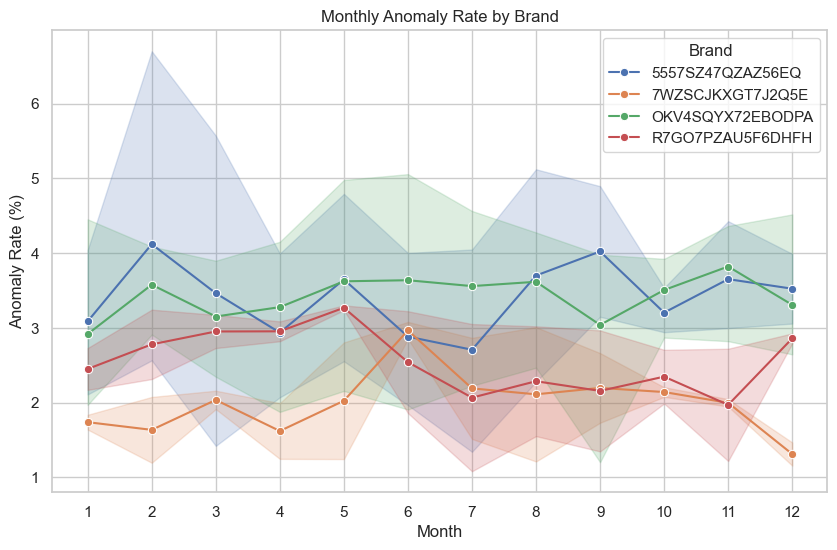

In [50]:
plt.figure(figsize=(10,6))
sns.lineplot(
    data=monthly_anomalies,
    x='month', y='anomaly_rate', hue='MARCA_COMP', marker='o'
)
plt.title('Monthly Anomaly Rate by Brand')
plt.xlabel('Month')
plt.ylabel('Anomaly Rate (%)')
plt.xticks(range(1,13))
plt.legend(title='Brand')
plt.show()


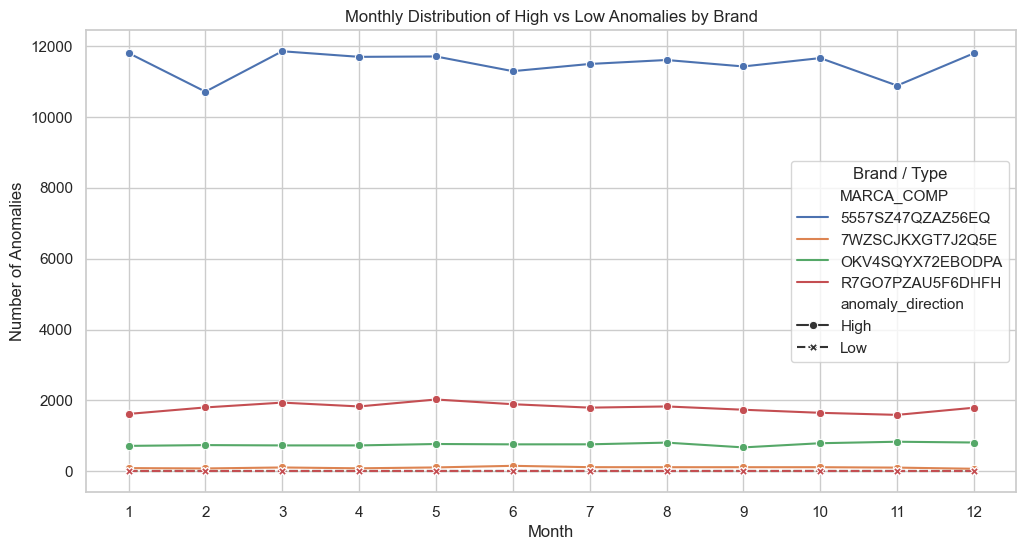

In [52]:
monthly_direction = (
    df_anomalies.groupby(['MARCA_COMP', 'month', 'anomaly_direction'])
    .agg(anomalies=('is_anomaly', 'sum'))
    .reset_index()
)

plt.figure(figsize=(12,6))
sns.lineplot(
    data=monthly_direction,
    x='month', y='anomalies',
    hue='MARCA_COMP', style='anomaly_direction', markers=True
)
plt.title('Monthly Distribution of High vs Low Anomalies by Brand')
plt.xlabel('Month')
plt.ylabel('Number of Anomalies')
plt.xticks(range(1,13))
plt.legend(title='Brand / Type')
plt.show()


In [53]:
# Group by brand + diameter + month
monthly_brand_diam = (
    df_anomalies.groupby(['MARCA_COMP', 'DIAM_COMP', 'month'])
    .agg(total=('CONSUMO_REAL', 'count'),
         anomalies=('is_anomaly', 'sum'))
    .reset_index()
)

# Compute anomaly rate per month
monthly_brand_diam['anomaly_rate'] = 100 * monthly_brand_diam['anomalies'] / monthly_brand_diam['total']
display(monthly_brand_diam.head())


,MARCA_COMP,DIAM_COMP,month,total,anomalies,anomaly_rate
0,5557SZ47QZAZ56EQ,15.0,1,391301,11760,3.005359
1,5557SZ47QZAZ56EQ,15.0,2,367629,10682,2.905647
2,5557SZ47QZAZ56EQ,15.0,3,402841,11839,2.938877
3,5557SZ47QZAZ56EQ,15.0,4,390319,11675,2.991143
4,5557SZ47QZAZ56EQ,15.0,5,403382,11677,2.894775


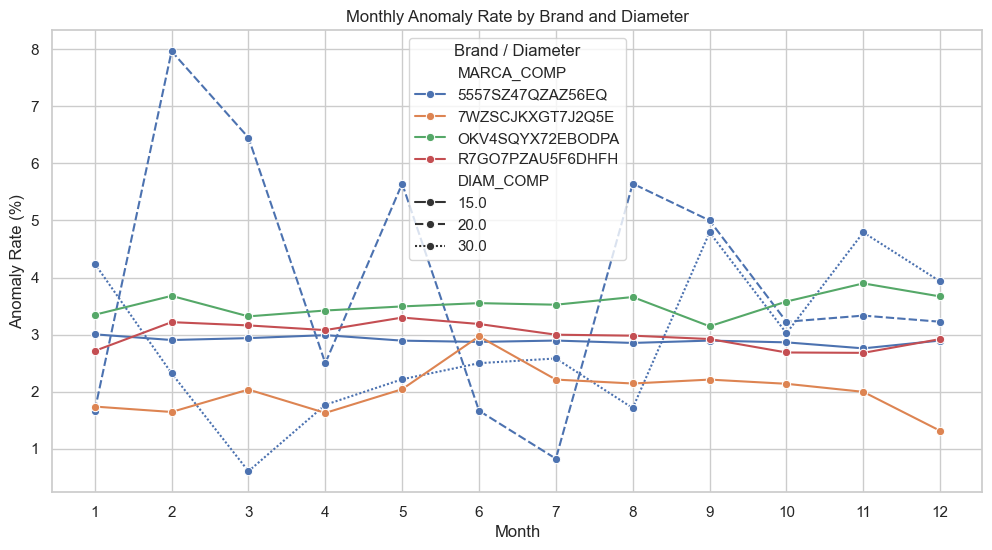

In [54]:
plt.figure(figsize=(12,6))
sns.lineplot(
    data=monthly_brand_diam,
    x='month', y='anomaly_rate',
    hue='MARCA_COMP', style='DIAM_COMP', marker='o'
)
plt.title('Monthly Anomaly Rate by Brand and Diameter')
plt.xlabel('Month')
plt.ylabel('Anomaly Rate (%)')
plt.xticks(range(1,13))
plt.legend(title='Brand / Diameter')
plt.show()


In [55]:
monthly_model_diam = (
    df_anomalies.groupby(['CODI_MODEL', 'DIAM_COMP', 'month'])
    .agg(total=('CONSUMO_REAL', 'count'),
         anomalies=('is_anomaly', 'sum'))
    .reset_index()
)
monthly_model_diam['anomaly_rate'] = 100 * monthly_model_diam['anomalies'] / monthly_model_diam['total']


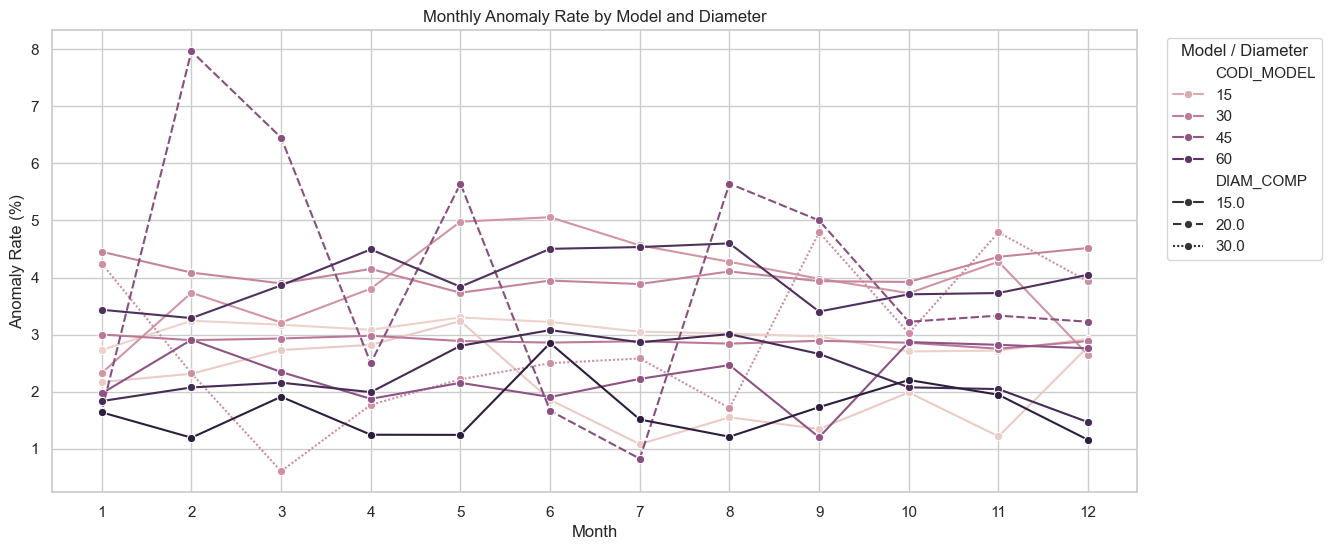

In [56]:
plt.figure(figsize=(14,6))
sns.lineplot(
    data=monthly_model_diam,
    x='month', y='anomaly_rate',
    hue='CODI_MODEL', style='DIAM_COMP', marker='o'
)
plt.title('Monthly Anomaly Rate by Model and Diameter')
plt.xlabel('Month')
plt.ylabel('Anomaly Rate (%)')
plt.xticks(range(1,13))
plt.legend(title='Model / Diameter', bbox_to_anchor=(1.02, 1))
plt.show()


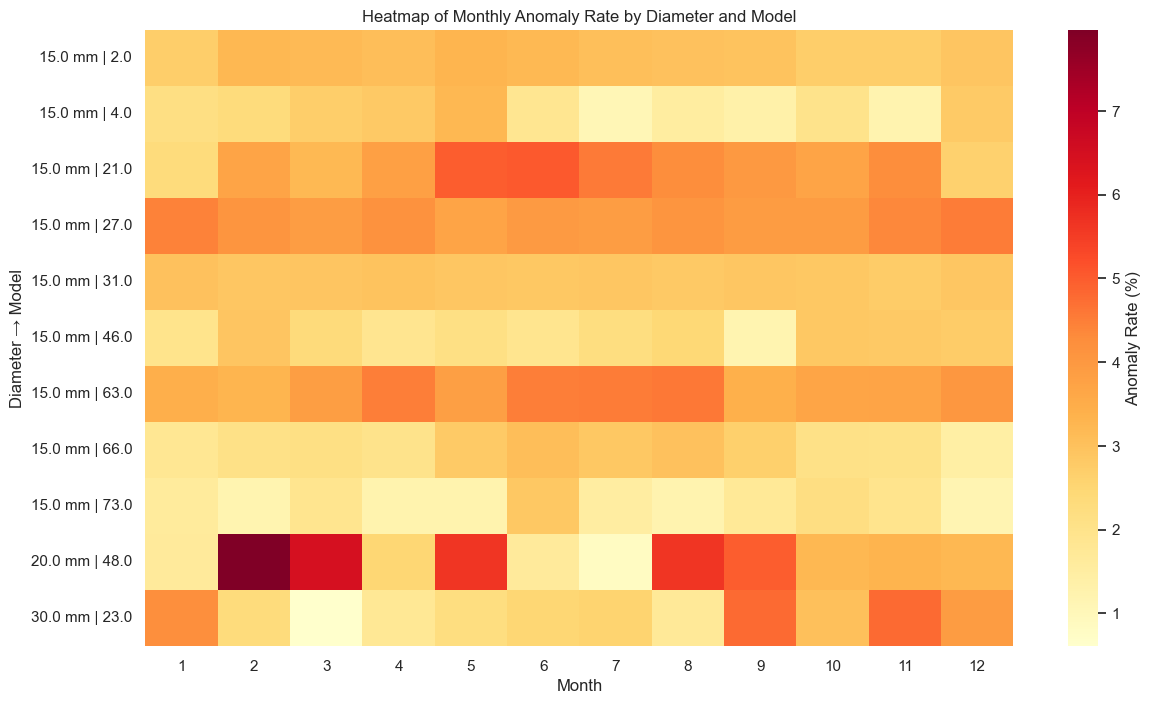

In [59]:
# Re-group putting diameter first, then model
heatmap_diam_model = (
    monthly_model_diam
    .groupby(['DIAM_COMP', 'CODI_MODEL', 'month'])['anomaly_rate']
    .mean()
    .unstack('month')
    .sort_index(level=[0,1])  # ensure logical ordering
)

# For a cleaner axis label (combine diameter and model)
heatmap_diam_model.index = [
    f"{diam} mm | {model}" for diam, model in heatmap_diam_model.index
]

# Plot
plt.figure(figsize=(14,8))
sns.heatmap(
    heatmap_diam_model,
    cmap='YlOrRd',
    annot=False,
    cbar_kws={'label': 'Anomaly Rate (%)'}
)
plt.title('Heatmap of Monthly Anomaly Rate by Diameter and Model')
plt.xlabel('Month')
plt.ylabel('Diameter → Model')
plt.show()
